In [18]:
import random
import numpy as np
import matplotlib
import math

import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms
from typing import List

plt.rcParams['figure.dpi'] = 150

In [36]:
class Orientation:
    HORIZONTAL = "H" 
    VERTICAL   = "V"
    
    ORIENTATION_LST = [HORIZONTAL, VERTICAL]
    
    @staticmethod
    def get_random():
        return random.choice(ORIENTATION_LST)
    
class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
    
    def collides(self, oth):
        return  not(       (oth.y >= self.y+self.height)\
                        or (oth.x >= self.x+self.width)\
                        or (oth.y+oth.height <= self.y)\
                        or (oth.x+oth.width <= self.x))
    
    def split_horizontal(self):
        h1 = math.ceil(self.height/2)
        h2 = self.height - h1
        return [Rectangle(self.width, h2, self.x, self.y+h1), Rectangle(self.width, h1, self.x, self.y)]
    
    def split_vertical(self):
        w1 = math.ceil(self.width/2)
        w2 = self.width - w1
        return [Rectangle(w1, self.height, self.x, self.y), Rectangle(w2, self.height, self.x+w1, self.y)]
        
        
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
class Facility:
    def __init__(self, ident):
        self.rectangle = None
        self.ident = ident
    
    def __str__(self):
        return f'{self.ident}'
        
class FacilityHelper:
    @staticmethod
    def get_rectangle(f: Facility) -> Rectangle:
        r = f.rectangle
        r.ident = f.ident
        return r

class Individual:
    def __init__(self, facility_sequence: List[Facility], slicing_order: List[int], orientation: List[Orientation]):
        IndividualValidator.validate_constructor_args(facility_sequence, slicing_order, orientation)
        self.facility_sequence = facility_sequence
        self.slicing_order = slicing_order
        self.orientation = orientation

class IndividualValidator:
        
    @staticmethod
    def validate_constructor_args(facility_sequence: List[int], slicing_order: List[int], orientation: List[Orientation]):
        n = len(facility_sequence)
        assert(n > 0)
        assert(n-1 == len(slicing_order))
        assert(n-1 == len(orientation))

class IndividualHelper:
    @staticmethod
    def get_rectangles(ind: Individual) -> List[Rectangle]:
        return [FacilityHelper.get_rectangle(f) for f in ind.facility_sequence]

class Placing:
    @staticmethod
    def set_facility_grid(ind: Individual, grid: Rectangle) -> None:
        Placing._set_recursively(ind.facility_sequence, ind.slicing_order, ind.orientation, grid)
    
    @staticmethod
    def _set_recursively(facility_sequence, slicing_order, orientation, grid) -> None:
        if len(slicing_order) == 0:
            return
        
        k = slicing_order[0]
        lf, rf = facility_sequence[:k], facility_sequence[k:]
        lc, rc = grid.split_horizontal() if orientation[0] == Orientation.HORIZONTAL else grid.split_vertical()
        
        Placing._place_if_single([(lf, lc), (rf, rc)])
        Placing._set_recursively(lf, *Placing._filter_up_to(slicing_order, orientation, k), lc)
        Placing._set_recursively(rf, *Placing._filter_after(slicing_order, orientation, k), rc)

    @staticmethod
    def _place_if_single(lst) -> None:
        for f,r in lst:
            if len(f) == 1:
                f[0].rectangle = r
            
    @staticmethod
    def _filter_up_to(slicing_order, orientation, k):
        slicing_order_new, orientation_new = [], []
        for x,y in zip(slicing_order, orientation):
            if x < k:
                slicing_order_new.append(x)
                orientation_new.append(y)
        return slicing_order_new, orientation_new
    
    @staticmethod
    def _filter_after(slicing_order, orientation, k):
        slicing_order_new, orientation_new = [], []
        for x,y in zip(slicing_order, orientation):
            if x > k:
                slicing_order_new.append(x-k)
                orientation_new.append(y)
        return slicing_order_new, orientation_new
        

def calculate_objective(facilities: List[Facility]) -> int:
    return -1
        
def evaluate_individual(ind: Individual, grid: Rectangle) -> List[int]:
    grid = create_facility_grid(ind)
    return [calculate_objective(grid)]

def evaluate_individual(individual: list, recs: List[Rectangle], strip_width: int) -> List[int]:
    ind_rec = individual_to_rectangles(individual, recs)
    place_rectangles(ind_rec, strip_width)
    return [calc_max_rectangle_height(ind_rec)]


###########################################################################################

def draw_rectangles(recs: List[Rectangle], grid: Rectangle, show_ident=True) -> None:
    def to_matplotlib_rec(rec):
        return matplotlib.patches.Rectangle(
            (rec.x, rec.y),
            width=rec.width,height=rec.height,
            edgecolor='blue',
            linewidth=1.3,
            fill=False,
        )
    fig, ax = plt.subplots()
    
    for rec in recs:
        ax.add_patch(to_matplotlib_rec(rec))
        if show_ident:
            ax.text(rec.x+rec.width/2, rec.y+rec.height/2, rec.ident, fontsize=8)


    ax.set_xlim(left=-1, right=grid.width+1)
    ax.set_ylim(bottom=-1, top=grid.height)
    ax.set_title(f'Slicing layout', fontsize=8)
    
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)    
    
    plt.show()

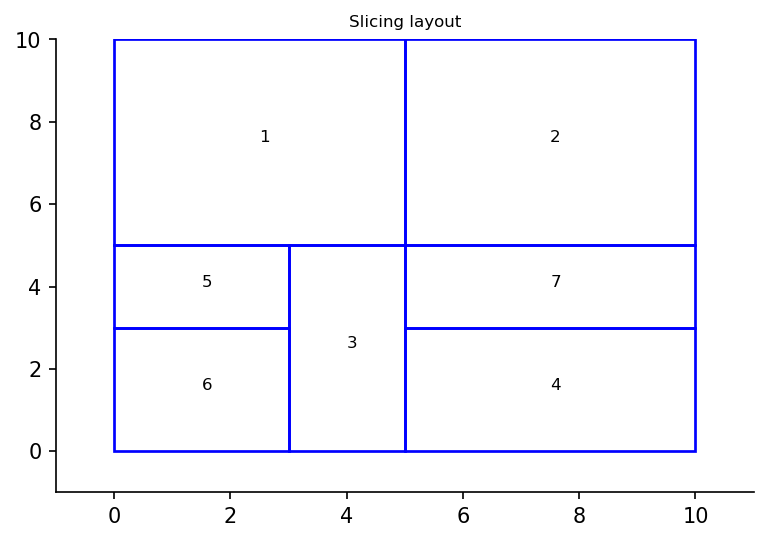

In [38]:
# example from paper
facility_sequence = [Facility(x) for x in [1, 5, 6, 3, 2, 7, 4]]
slicing_order = [4, 1, 5, 3, 6, 2]
orientation = [0, 1, 1, 0, 1, 1]
orientation = ['V', 'H', 'H', 'V', 'H', 'H']

# facility_sequence = [Facility(x) for x in [1, 2, 3]]
# slicing_order = [1, 2]
# orientation = [0, 1]

grid = Rectangle(width=10, height=10, x=0, y=0, ident='grid')

ind = Individual(facility_sequence, slicing_order, orientation)
Placing.set_facility_grid(ind, grid)
recs = IndividualHelper.get_rectangles(ind)
draw_rectangles(recs, grid)

In [ ]:
# Dummy instance
seq = iter(range(1,400))
recs = [
    Rectangle(width=1, height=1, ident='A'),
    Rectangle(width=2, height=1, ident='B'),
    Rectangle(width=3,height=3, ident='C'),
    Rectangle(width=1,height=4, ident='D'),
    Rectangle(width=3,height=1, ident='E'),
]
strip_width = 5

place_rectangles(recs, strip_width)
draw_rectangles(recs, strip_width)

In [ ]:
def run_ga(toolbox, initial_population_size=10, ngen=10,mutpb=0.0):
    pop = toolbox.population(n=initial_population_size)
    hof = tools.HallOfFame(1)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

def display_run_info(pop, logbook, hof): 
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

    gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# parameters
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_random", np.random.rand)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_random, n=len(recs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual, recs=recs, strip_width=strip_width)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

pop, logbook, hof = run_ga(toolbox)
# draw_rectangles(recs, strip_width)
draw_rectangles(individual_to_rectangles(hof[0], recs), strip_width)

# Random instance

In [11]:
# Bigger dataset
n_rec = 30

recs = []
np.random.seed(seed=42)
for ident in range(n_rec):
    width = np.random.randint(low=1, high=20)
    height = np.random.randint(low=1, high=20)
    recs.append(Rectangle(width=width, height=height, ident=ident))
    
strip_width = 20



# parameters
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox2 = base.Toolbox()
toolbox2.register("attr_random", np.random.rand)
toolbox2.register("individual", tools.initRepeat, creator.Individual, toolbox2.attr_random, n=len(recs))
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)
toolbox2.register("evaluate", evaluate_individual, recs=recs, strip_width=strip_width)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox2.register("select", tools.selTournament, tournsize=5)

pop, logbook, hof = run_ga(toolbox2, initial_population_size=10, ngen=50, mutpb=0.2)

display_run_info(pop, logbook, hof)
draw_rectangles(individual_to_rectangles(hof[0], recs), strip_width, show_ident=False)

# heuristic alone
place_rectangles(recs, strip_width)
draw_rectangles(recs, strip_width, show_ident=False)

NameError: name 'run_ga' is not defined